In [1]:
%load_ext autoreload
%autoreload 2

import pathlib

import numpy as np
import pandas as pd
import xarray as xr
import copernicusmarine

from tqdm.dask import TqdmCallback as ProgressBar

import oceansoda_ethzv2 as ocn
import oceansoda_ethzv2.data.co2atm
import oceansoda_ethzv2.data.utils.smoothing
import oceansoda_ethzv2.data.processors as p
import oceansoda_ethzv2.data.checker as checker

/Users/luke/Git/OceanSODA-ETHZv2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if False:
    cmems = ocn.data.cmems.CMEMSCatalog.from_yaml('./cmems_datasets.yaml')
    era5 = ocn.data.era5.ERA5Dataset.init_with_defaults()

    cmems.write_timestep_to_disk(2022, 3, progress=True)
    era5.write_timestep_to_disk(2020, 1, progress=True)

In [3]:
from oceansoda_ethzv2.data.soda import get_soda_data_for_window

2025-05-25 19:27:55.499 | DEBUG    | oceansoda_ethzv2.data.checker:check_land_points:159 - Ocean/Land check passed for the first variable [sss] of the dataset.
2025-05-25 19:27:55.500 | DEBUG    | oceansoda_ethzv2.data.checker:check_missing_lon:237 - No missing longitude values found in the first variable [sss] of the dataset.
2025-05-25 19:27:55.501 | WARNING  | oceansoda_ethzv2.data.checker:fix_timestep:206 - Time fixed. Time coordinate 2022-01-04 12:00:00 did not match expected time 2022-01-05 00:00:00. Adjusted to 2022-01-05 00:00:00.
2025-05-25 19:27:55.501 | WARNING  | oceansoda_ethzv2.data.checker:add_time_bnds:50 - Time bounds are missing, adding them.


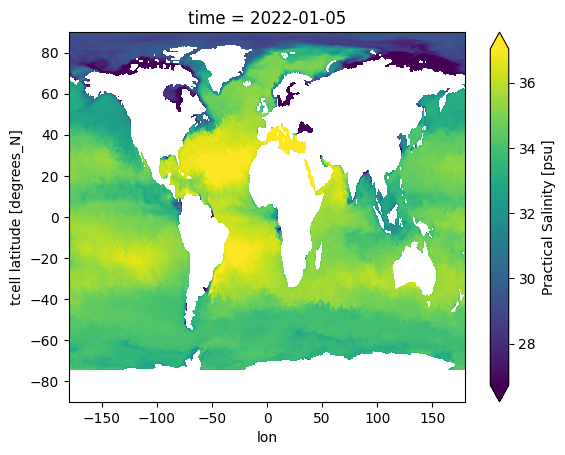

In [23]:
get_soda_data_for_window(pd.Timestamp('2022-01-01'),).sss.plot(robust=True)

In [63]:
check = checker.TimestepChecker()

dw = ocn.data.DateWindows(window_span='8D')
t0, t1 = dw.get_window_edges(time)

target_grid = ocn.data.processors.make_target_global_grid(0.25)

out = (
    ds
    .resample(time='1D').interpolate(kind='linear')
    .sel(time=slice(t0, t1))
    .coarsen(time=8).mean()
    .interp(**target_grid, method='linear')
    .reindex(**target_grid, method='nearest', tolerance=0.5)
    .roll(lon=360, roll_coords=False)
    .interpolate_na(dim='lon', method='linear', limit=2)
    .roll(lon=-360, roll_coords=False)
    .compute()
    )

In [65]:
check.check_lon_lat(out)
check.check_land_points(out)
check.check_missing_lon(out)
out = check.add_time_bnds(out)
out = check.fix_timestep(out)

2025-05-25 19:11:06.141 | DEBUG    | oceansoda_ethzv2.data.checker:check_land_points:159 - Ocean/Land check passed for the first variable [sss] of the dataset.
2025-05-25 19:11:06.143 | DEBUG    | oceansoda_ethzv2.data.checker:check_missing_lon:237 - No missing longitude values found in the first variable [sss] of the dataset.
2025-05-25 19:11:06.143 | DEBUG    | oceansoda_ethzv2.data.checker:add_time_bnds:47 - Time bounds already exist in the dataset.
2025-05-25 19:11:06.144 | DEBUG    | oceansoda_ethzv2.data.checker:fix_timestep:208 - Time coordinate 2020-01-05 00:00:00 matches expected time 2020-01-05 00:00:00.


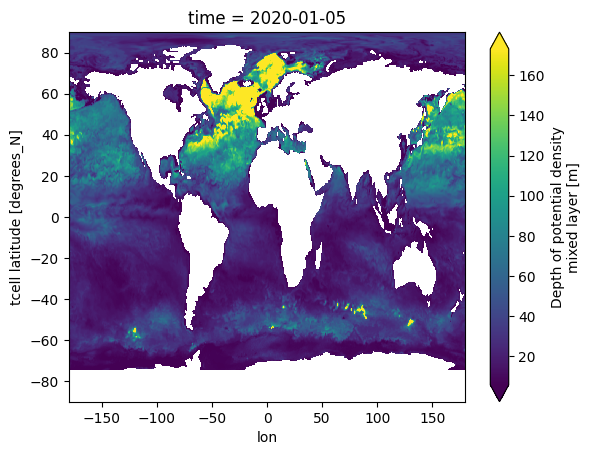

In [68]:
out.mld.plot(robust=True)

In [37]:
logger = logging.getLogger('pooch')

In [44]:
logger.warning('test')

In [ ]:
soda_rename = {
    'xt_ocean': 'lon',
    'yt_ocean': 'lat',
    'st_ocean': 'depth',
    'salt': 'sss',
    'ssh': 'ssh',
    'mlp': 'mld'}

In [ ]:
ds = ocn.data.soda.soda_preprocessor

In [ ]:
dA = ds.isel(time=0)
dB = ds.isel(time=1)

In [ ]:
pd.Timedelta((dA.time - dB.time).values.astype('timedelta64[ns]'))

Timedelta('-5 days +00:00:00')

In [ ]:
ssh_vars = {
    'latitude': 'lat',
    'longitude': 'lon',
    'adt': 'adt',
    'sla': 'sla',
    'err_sla': 'sla_sigma_uncert'}

ds = copernicusmarine.open_dataset(
    dataset_id='cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D',
    dataset_version='202411',
    dataset_part='default')

ds = (
    p.rename_and_drop(ds, ssh_vars)
    .sel(time='2024')
    .pipe(p.coarsen_and_interp_daily)
    .astype(np.float32)
    .chunk({'time': 1, 'lat': 360, 'lon': 360}))

INFO - 2025-05-24T08:21:20Z - Selected dataset version: "202411"
INFO - 2025-05-24T08:21:20Z - Selected dataset part: "default"


Munch({'boundary': 'pad', 'time': 8, 'lat': 2, 'lon': 2})


In [ ]:
with ProgressBar():
    out = ds.persist()

 10%|█         | 12053/117187 [00:25<03:42, 471.99it/s]


KeyboardInterrupt: 

In [ ]:
out

<xarray.Dataset> Size: 850MB
Dimensions:           (time: 41, lat: 720, lon: 1440)
Coordinates:
  * time              (time) datetime64[ns] 328B 2024-01-04T12:00:00 ... 2024...
  * lat               (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon               (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
Data variables:
    adt               (time, lat, lon) float32 170MB dask.array<chunksize=(1, 80, 1440), meta=np.ndarray>
    sla               (time, lat, lon) float32 170MB dask.array<chunksize=(1, 80, 1440), meta=np.ndarray>
    sla_sigma_uncert  (time, lat, lon) float32 170MB dask.array<chunksize=(1, 80, 1440), meta=np.ndarray>
    adt_sigma_regrid  (time, lat, lon) float32 170MB dask.array<chunksize=(1, 80, 1440), meta=np.ndarray>
    sla_sigma_regrid  (time, lat, lon) float32 170MB dask.array<chunksize=(1, 80, 1440), meta=np.ndarray>
Attributes:
    contact:      servicedesk.cmems@mercator-ocean.eu
    institution:  CLS, CNES
    references:   http://marine.copernicus.eu
    title:        DT merged all satellites Global Ocean Gridded SSALTO/DUACS ...
    comment:      Sea Surface Height measured by Altimetry and derived variables
    history:      2024-10-23 12:55:06Z: Creation
    source:       Altimetry measurements
    Conventions:  CF-1.6